In [21]:
# Import our dependencies
from sqlalchemy import create_engine
from config import user
from config import password2
from urllib import parse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint

### Connect to the database and extract data into a dataframe

In [22]:
# Creating a connection string for the Glassdoor database
protocol="postgresql"
username=user
password=parse.quote(password2)
host="localhost"
port=5432
database_name="Glassdoor_Reviews"

Con_Str=f"{protocol}://{username}:{password}@{host}:{port}/{database_name}"
        
# Create an engine instance
Con = create_engine(Con_Str)

# Connect to PostgreSQL server
dbConnection = Con.connect();

# Read data from PostgreSQL database table and load into a DataFrame instance
df = pd.read_sql("select * from glassdoor", dbConnection);

# Close the database connection
dbConnection.close();

In [23]:
# Display the dataframe
df.head(5)

,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons
0,AFH-Wealth-Management,2020-10-01,Office Administrator,"Former Employee, more than 3 years","Bromsgrove, England, England",2,1.0,3.0,1.0,1.0,2.0,2.0,x,o,x,The people both make and destroy this place,"Great people in some places, excellent Christm...","Poor pay, huge gap for pay between senior mana..."
1,AFH-Wealth-Management,2021-02-05,Quality Control,Former Employee,"Birmingham, England, England",1,3.0,1.0,2.0,1.0,1.0,1.0,x,o,o,Very low salaries,"Majority of the people there are lovely, and t...",Salaries are much lower than market competitor...
2,AFH-Wealth-Management,2021-02-07,IFA Administrator,"Former Employee, less than 1 year","Bromsgrove, England, England",4,3.0,3.0,4.0,4.0,4.0,2.0,v,o,v,Good,"Nice environment, love people, not too stressful",Management can be clicky at times
3,AFH-Wealth-Management,2021-02-07,Investment Operations,"Former Employee, more than 1 year","Birmingham, England, England",3,5.0,5.0,4.0,3.0,1.0,2.0,x,o,v,AFH Review,-Great People\n-Heading in a good direction ge...,-Low Salary\n-Middle Management likes to micro...
4,AFH-Wealth-Management,2021-05-12,Client Engagement Executive,"Former Employee, less than 1 year","Birmingham, England, England",1,1.0,2.0,1.0,1.0,1.0,1.0,x,x,x,Terrible- avoid like the plague,"None, they lie about working hours, bonuses, p...",-Unachievable bonus unfairly set by manager\n-...


### Determine the correlation between attributes of the dataset using Seaborn

In [24]:
# compute the correlation matrix
corr = df.corr()
corr

,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt
overall_rating,1.000000,0.576271,0.757659,0.623362,0.686137,0.622077,0.738551
work_life_balance,0.576271,1.000000,0.576312,0.494338,0.399630,0.462999,0.555938
culture_values,0.757659,0.576312,1.000000,0.715903,0.634250,0.577421,0.743550
diversity_inclusion,0.623362,0.494338,0.715903,1.000000,0.544574,0.473536,0.640179
career_opp,0.686137,0.399630,0.634250,0.544574,1.000000,0.577133,0.659614
comp_benefits,0.622077,0.462999,0.577421,0.473536,0.577133,1.000000,0.569976
senior_mgmt,0.738551,0.555938,0.743550,0.640179,0.659614,0.569976,1.000000


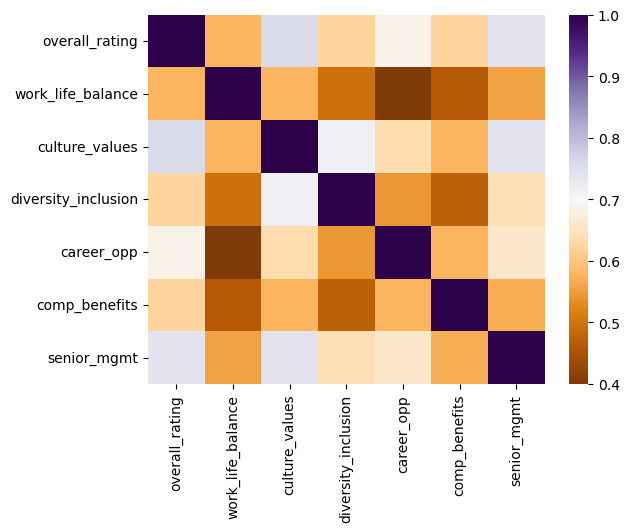

In [25]:
# create a heatmap using Seaborn
sns.heatmap(corr, cmap="PuOr")

# show the plot
plt.show()

### Preprocess the data before creating a model

In [26]:
# List all the attributes of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104510 entries, 0 to 104509
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   firm                 104510 non-null  object 
 1   date_review          104510 non-null  object 
 2   job_title            104510 non-null  object 
 3   current              104510 non-null  object 
 4   location             104510 non-null  object 
 5   overall_rating       104510 non-null  int64  
 6   work_life_balance    104510 non-null  float64
 7   culture_values       104510 non-null  float64
 8   diversity_inclusion  104510 non-null  float64
 9   career_opp           104510 non-null  float64
 10  comp_benefits        104510 non-null  float64
 11  senior_mgmt          104510 non-null  float64
 12  recommend            104510 non-null  object 
 13  ceo_approv           104510 non-null  object 
 14  outlook              104510 non-null  object 
 15  headline         

In [27]:
# Drop the non-beneficial columns.
df_clean = df.drop(["firm", "date_review", "job_title", "location", "current", "headline", "pros", "cons"], axis=1)
df_clean.head(5)

,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook
0,2,1.0,3.0,1.0,1.0,2.0,2.0,x,o,x
1,1,3.0,1.0,2.0,1.0,1.0,1.0,x,o,o
2,4,3.0,3.0,4.0,4.0,4.0,2.0,v,o,v
3,3,5.0,5.0,4.0,3.0,1.0,2.0,x,o,v
4,1,1.0,2.0,1.0,1.0,1.0,1.0,x,x,x


In [28]:
# Drop columns further, considering the seaborn heatmap
df_clean.drop(["work_life_balance", "diversity_inclusion", "comp_benefits", "recommend", "ceo_approv", "outlook"], axis=1, inplace=True)
df_clean.head(5)

,overall_rating,culture_values,career_opp,senior_mgmt
0,2,3.0,1.0,2.0
1,1,1.0,1.0,1.0
2,4,3.0,4.0,2.0
3,3,5.0,3.0,2.0
4,1,2.0,1.0,1.0


In [29]:
# List all the available attributes of the dataframe
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104510 entries, 0 to 104509
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall_rating  104510 non-null  int64  
 1   culture_values  104510 non-null  float64
 2   career_opp      104510 non-null  float64
 3   senior_mgmt     104510 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 3.2 MB


In [30]:
df_clean.nunique()

overall_rating    5
culture_values    5
career_opp        5
senior_mgmt       5
dtype: int64

In [31]:
# Split our preprocessed data into our features and target arrays
X = df_clean.drop("overall_rating", axis=1)
y = df_clean["overall_rating"]

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [32]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Compile, Train and Evaluate the Model

In [33]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

# Size of data is the number of input features
input_features = X.shape[1]
print("Input Features:",input_features)

# Size of the output layer
output_layer_size = 1
print("Output Layer Size:",output_layer_size)
 
# The number of hidden neurons here is less than twice the size of the input layer    
hidden_nodes_1 = (input_features * 2) - 1
print("Hidden nodes in layer 1:", hidden_nodes_1)

# The number of hidden neurons here is 2/3 the size of the input layer, plus the size of the output layer
nodes2 = input_features * (2/3)
hidden_nodes_2 = round(nodes2,0) + output_layer_size
print("Hidden nodes in layer 2:", int(hidden_nodes_2))

Input Features: 3
Output Layer Size: 1
Hidden nodes in layer 1: 5
Hidden nodes in layer 2: 3


In [34]:
# Create a Keras Sequential model
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_1, activation="relu", input_dim=input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_2, activation="relu"))

# Output layer - Linear activation model used by default if not given specifically
nn.add(tf.keras.layers.Dense(units=1))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 5)                 20        
                                                                 
 dense_4 (Dense)             (None, 3)                 18        
                                                                 
 dense_5 (Dense)             (None, 3)                 12        
                                                                 
 dense_6 (Dense)             (None, 1)                 4         
                                                                 
Total params: 54
Trainable params: 54
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Compile the model
nn.compile(loss='mean_squared_error', optimizer="adam", metrics=["accuracy"])

In [36]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=10)

Epoch 1/10
2450/2450 [==============================] - 6s 2ms/step - loss: 1.8313 - accuracy: 0.0541
Epoch 2/10
2450/2450 [==============================] - 5s 2ms/step - loss: 0.4322 - accuracy: 0.0578
Epoch 3/10
2450/2450 [==============================] - 5s 2ms/step - loss: 0.4243 - accuracy: 0.0578
Epoch 4/10
2450/2450 [==============================] - 5s 2ms/step - loss: 0.4213 - accuracy: 0.0578
Epoch 5/10
2450/2450 [==============================] - 5s 2ms/step - loss: 0.4197 - accuracy: 0.0578
Epoch 6/10
2450/2450 [==============================] - 5s 2ms/step - loss: 0.4192 - accuracy: 0.0578
Epoch 7/10
2450/2450 [==============================] - 5s 2ms/step - loss: 0.4185 - accuracy: 0.0578
Epoch 8/10
2450/2450 [==============================] - 5s 2ms/step - loss: 0.4181 - accuracy: 0.0578
Epoch 9/10
2450/2450 [==============================] - 5s 2ms/step - loss: 0.4181 - accuracy: 0.0578
Epoch 10/10
2450/2450 [==============================] - 5s 2ms/step - loss: 0.417

In [37]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

817/817 - 1s - loss: 0.4258 - accuracy: 0.0576 - 1s/epoch - 2ms/step
Loss: 0.42580652236938477, Accuracy: 0.05756276845932007
